# Cats vs Dogs 


This notebook explores using the pretrained model, EfficientNetB0, on a image classification problems utilizing the tfds cats_vs_dogs dataset

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-03-06 19:35:19--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-06 19:35:19 (64.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Standard imports
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import itertools

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import mixed_precision 
# Get TensorFlow Datasets
import tensorflow_datasets as tfds


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Create tensorboard callback (import from helper_functions)
from helper_functions import create_tensorboard_callback

First we will check to ensure that the cats_vs_dogs dataset is in the tfds dataset list

In [4]:
# List all available datasets
datasets_list = tfds.list_builders()
print('cats_vs_dogs' in datasets_list)

True


Now that it is confirmed we will download that dataset and split it into our train and test data with a 70/30 ratio

In [5]:
# Load in the data 
(train_data, test_data), ds_info = tfds.load(name = 'cats_vs_dogs',
                                             split = ['train[:70%]', 'train[70%:]'],
                                             shuffle_files = True,
                                             as_supervised =True, 
                                             with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete1L05T5/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


Let's check the features of our dataset to see what type of data we are working with

In [6]:
# Features of cats_vs_dogs from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
})

In [7]:
# Get the class names 
class_names = ds_info.features["label"].names
class_names

['cat', 'dog']

Let's visualize a sample image 

In [8]:
# Take one sample of the data 
train_one_sample = train_data.take(1)
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [9]:
# Output info about our training sample 
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form) : {class_names[label.numpy()]}
  """)


  Image shape: (500, 345, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 1
  Class name (str form) : dog
  


In [10]:
# what are the min and max values of our image tensor 
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

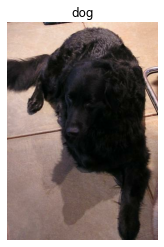

In [11]:
# Plot an image tensor 

plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## Create modelling callbacks
we're going to create a couple callbacks to help us while our model trains

TensorBoard callback to log training results (so we can visualzie them later if need be)
ModelCheckpoint callback to save our model's progress after feature extraction

In [12]:
# Create ModelCheckpoint callback to save a model's progress during training 
checkpoint_path = 'model_checkpoints/cp.ckpt'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor = 'val_accuracy',
                                                      save_best_only = True, 
                                                      save_weights_only = True,
                                                      verbose = 0)

## Create preprocessing functions for our data


In [13]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape = 224):
  """
  Converts image datatype from `uunit8` -> `float32` and reshape 
  image to [img_shape, img_shape, color_channels]
  """

  image = tf.image.resize(image, [img_shape, img_shape])
  #image = image/255. # not required for efficeintnetb0 as it has it inbuilt
  return tf.cast(image, tf.float32), label # return a tuuple of (float32_image, label)


In [14]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f" Image before preprocessing:\n {image[:2]}. \nShape: {image.shape}, \nDatatype: {image.dtype}\n")
print(f" Image after preprocessing: \n {preprocessed_img[:2]}. \nShape: {preprocessed_img.shape}, \nDatatype: {preprocessed_img.dtype}\n")

 Image before preprocessing:
 [[[140 102  89]
  [137  99  86]
  [130  94  80]
  ...
  [233 193 168]
  [236 196 171]
  [235 195 170]]

 [[150 112  99]
  [157 119 106]
  [167 131 117]
  ...
  [231 191 166]
  [232 192 167]
  [231 191 166]]]. 
Shape: (500, 345, 3), 
Datatype: <dtype: 'uint8'>

 Image after preprocessing: 
 [[[147.01439 109.01439  96.01439]
  [152.13567 115.7562  101.94593]
  [155.70627 119.70626 105.70626]
  ...
  [230.83199 190.83199 165.83199]
  [232.10327 192.10327 167.10327]
  [232.80583 192.80583 167.80583]]

 [[206.37158 170.37158 156.37158]
  [206.908   170.908   156.908  ]
  [202.72023 166.72023 152.72023]
  ...
  [229.90591 189.90591 164.90591]
  [228.31271 188.31271 163.31271]
  [229.84068 189.84068 164.84068]]]. 
Shape: (224, 224, 3), 
Datatype: <dtype: 'float32'>



## Batch & prepare datasets

we're now going to make out data input pipeline run really fast.

For more information on this refer to : https://www.tensorflow.org/guide/data_performance

In [15]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func =preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
#Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size = 1000).batch(batch_size = 32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data 
test_data = test_data.map(map_func =preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)


In [16]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

We will be using the EfficientNetB0 model as a base model 

In [17]:
# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape = input_shape, name = 'input_layer')
# Note: EfficientNetBX models have rescaling built-in but if your model doesn't, you can use something like below
# x = preprocessing.Rescaling(1./255)
x = base_model(inputs, training = False) # make sure layers which should be in inference mode only stay like that 
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype = tf.float32, name = "softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

16705208/16705208 [==============================] - 0s 0us/step


In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
 softmax_float32 (Activation  (None, 2)                0         
 )                                                               
                                                                 
Total params: 4,052,133
Trainable params: 2,562
Non-trainable

In [19]:
# Check the dytpe of each layer 
for layer in model.layers:
  print(f"Layer name: {layer.name} \nLayer trainable: {layer.trainable} \nLayer dtype:{layer.dtype} \nLayer policy: {layer.dtype_policy}")

Layer name: input_layer 
Layer trainable: True 
Layer dtype:float32 
Layer policy: <Policy "float32">
Layer name: efficientnetb0 
Layer trainable: False 
Layer dtype:float32 
Layer policy: <Policy "float32">
Layer name: global_average_pooling2d 
Layer trainable: True 
Layer dtype:float32 
Layer policy: <Policy "float32">
Layer name: dense 
Layer trainable: True 
Layer dtype:float32 
Layer policy: <Policy "float32">
Layer name: softmax_float32 
Layer trainable: True 
Layer dtype:float32 
Layer policy: <Policy "float32">


In [20]:
# Fit the feature extraction model with callbacks 
cat_dog_classses_feature_extract = model.fit(train_data,
                                                      epochs = 3,
                                                      steps_per_epoch = (len(train_data)),
                                                      validation_data = test_data,
                                                      validation_steps = int(0.15 * len(test_data)))

Epoch 1/3
509/509 [==============================] - 1508s 3s/step - loss: 0.0494 - accuracy: 0.9865 - val_loss: 0.0268 - val_accuracy: 0.9893
Epoch 2/3
509/509 [==============================] - 1412s 3s/step - loss: 0.0206 - accuracy: 0.9942 - val_loss: 0.0237 - val_accuracy: 0.9902
Epoch 3/3
509/509 [==============================] - 1495s 3s/step - loss: 0.0171 - accuracy: 0.9945 - val_loss: 0.0233 - val_accuracy: 0.9902


In [21]:
# Evaluate model on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

219/219 [==============================] - 577s 3s/step - loss: 0.0219 - accuracy: 0.9928


[0.0218800138682127, 0.9928356409072876]